### Inference
    Inference is nothing but "making predictions" given the data X based on parameters either learned or unlearned. Like making predictions of training data X_train using the parameters of w and b or even making prediction with the new data X_new. One round of forward prob can also be seen as inference

In [1]:
import tensorflow as tf
import numpy as np
np.set_printoptions(precision=2)

In [2]:
tf.__version__

'2.13.0'

In [3]:
np.__version__

'1.23.4'

In [4]:
import sys
sys.version #python version

'3.8.10 (default, May 19 2021, 13:12:57) [MSC v.1916 64 bit (AMD64)]'

In [5]:
#Building simple neural network
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Normalization
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.losses import BinaryCrossentropy, mean_squared_error
from tensorflow.keras.optimizers import SGD
from matplotlib import colors as colors
from matplotlib import cm

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

In [6]:
#some notes
np.set_printoptions(precision=10)
rng = np.random.default_rng(2) #seed of 2
X = rng.random(400)
X = X.reshape(-1, 2)
print(X[:5])
X[:, 0] = X[:, 0] * (285 - 150) + 150 #reverse scaling of feature 1
X[:, 1] = X[:, 1] * 4 + 11.5  #reverse scaling of feature 2
print(X[:5])
print(np.min(X, axis=0))
print(np.max(X, axis=0))

# x_scaled = (x_orig - xmin) / (xmax - xmin)
# x_orig = x_scaled * (xmax - xmin) + xmin

[[0.2616121342 0.2984911434]
 [0.8142257406 0.0919159421]
 [0.600100526  0.7285605268]
 [0.1879010734 0.0551466273]
 [0.2749693679 0.6574330149]]
[[185.3176381237  12.6939645737]
 [259.9204749802  11.8676637685]
 [231.0135710054  14.4142421072]
 [175.3666449045  11.7205865093]
 [187.1208646673  14.1297320595]]
[151.3237221213  11.5127470825]
[284.9943416745  15.4542069288]


In [7]:
#generating coffee roast data
def load_coffee_data():
    rng = np.random.default_rng(2)
    X = rng.random(400) #generates 400 random numbers array, ranging between 0 and 1 i.e min max scaled
    X = X.reshape(-1, 2) #(200, 2) - 2 columns, 200 rows each col -  assume first col represent degrees, second col represents duration
    
    #Reverse scaling to original number
    X[:, 0] = X[:, 0] * (285 - 150) + 150 #temp Degrees ranging from 150 C to 285 C =~ 300F to 545 F (Formula of F = celsius * (9/5) + 32)
    X[:, 1] = X[:, 1] * (15.5 - 11.5) + 11.5 #temp duration ranging from 11.5 to 15.5 mins
    Y = np.zeros(len(X))
    #assuming 175 C- 260 C, 12 min - 15 min are best for coffee roasting i.e in this range, Y would be 1
    
    #generating Y's
    i = 0
    for temp, dur in X:
        y_line = (12 - 15) / (260 - 175) * temp + 21
        #we are generating line across the good roasting process points y = mx + c
        # (12 - 15) / (260-175) gives us the slope of the slanting purpleline in the plot = y2 - y1 / x2 - x1
        # 12 - 15 = -3 indicate the line is decreasing slope line
        # 21 is the intercept i.e where the line touches the y axis
        
        if (175 < temp < 260) and (12 < dur < 15) and (dur<=y_line):
            Y[i] = 1
        else:
            Y[i] = 0
        i += 1
    return (X, Y.reshape(-1, 1))

X, y = load_coffee_data()
print(f"X.shape - {X.shape}")
print(f"y.shape - {y.shape}")
print(f"First 5 elements of X : \n{X[:5]}")
print(f"Unique elements of Y : \n{np.unique(y)}")

X.shape - (200, 2)
y.shape - (200, 1)
First 5 elements of X : 
[[185.3176381237  12.6939645737]
 [259.9204749802  11.8676637685]
 [231.0135710054  14.4142421072]
 [175.3666449045  11.7205865093]
 [187.1208646673  14.1297320595]]
Unique elements of Y : 
[0. 1.]


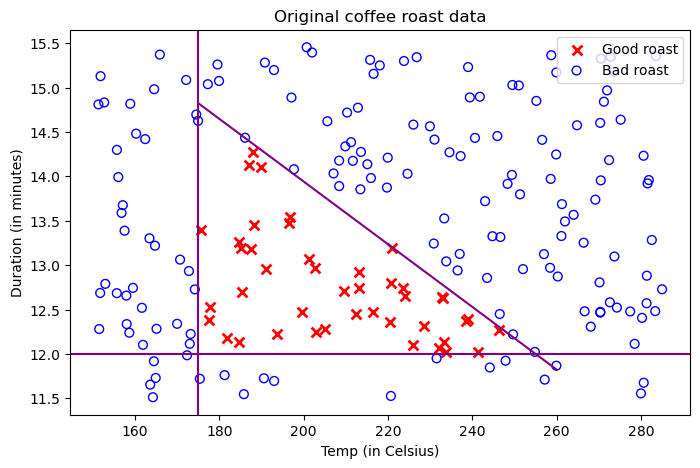

In [8]:
#plotting the original data
def plt_roast(X, y):
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    y = y.reshape(-1) #reshaping the 2d y to 1d y to get below the index properly
    pos = y==1
    neg = y==0
    ax.scatter(X[pos, 0], X[pos, 1], label="Good roast", c="red", marker="x", lw=2, s=50)
    ax.scatter(X[neg, 0], X[neg, 1], label="Bad roast", marker="o", lw=1, facecolors="none", edgecolors="blue", s=40)
    temp_range = np.linspace(175, 260, 50)
    ax.plot(temp_range, (-3 / 85) * temp_range + 21, c="purple") #plot the slanting line
    ax.axhline(y=12, c="purple") #horizontal line
    ax.axvline(x=175, c="purple") #vertical line
    ax.legend(loc="upper right")
    ax.set_xlabel("Temp (in Celsius)")
    ax.set_ylabel("Duration (in minutes)")
    ax.set_title("Original coffee roast data")
    plt.show()
    
plt_roast(X, y)

In [9]:
#Keras Normalization - Standardization 
print(f"Temperature Max, Min pre normalization: {np.max(X[:, 0]):0.2f}, {np.min(X[:, 0]):0.2f}")
print(f"Duration    Max, Min pre normalization: {np.max(X[:, 1]):0.2f}, {np.min(X[:, 1]):0.2f}")

#Normalization
norm_layer = tf.keras.layers.Normalization(axis=-1)
norm_layer.adapt(X) # learns mean, variance
X_scaled = norm_layer(X)
print(f"Temperature Max, Min pre normalization: {np.max(X_scaled[:, 0]):0.2f}, {np.min(X_scaled[:, 0]):0.2f}")
print(f"Duration    Max, Min pre normalization: {np.max(X_scaled[:, 1]):0.2f}, {np.min(X_scaled[:, 1]):0.2f}")

Temperature Max, Min pre normalization: 284.99, 151.32
Duration    Max, Min pre normalization: 15.45, 11.51
Temperature Max, Min pre normalization: 1.66, -1.69
Duration    Max, Min pre normalization: 1.79, -1.70


In [10]:
#Tile/copy our data to increase the training set size and reduce the number of training epochs.
X_train = np.tile(X_scaled, (1000, 1))
y_train = np.tile(y, (1000, 1))
print(X_train.shape, y_train.shape) 

(200000, 2) (200000, 1)


In [11]:
#Creating the network architecture
tf.random.set_seed(1234) # applied to achieve consistent results
model = Sequential([
    Input(shape=(2,)),
    Dense(units=3, activation="sigmoid", name="l1"),
    Dense(units=1, activation="sigmoid", name="l2")
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 l1 (Dense)                  (None, 3)                 9         
                                                                 
 l2 (Dense)                  (None, 1)                 4         
                                                                 
Total params: 13 (52.00 Byte)
Trainable params: 13 (52.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


    Note 1: The tf.keras.Input(shape=(2,)), specifies the expected shape of the input. This allows Tensorflow to size the weights and bias parameters at this point. This is useful when exploring Tensorflow models. This statement can be omitted in practice and Tensorflow will size the network parameters when the input data is specified in the model.fit statement.

    Note 2: Including the sigmoid activation in the final layer is not considered best practice. It would instead be accounted for in the loss which improves numerical stability. This will be described in more detail in a later lab.
    
    The parameter counts shown in the summary correspond to the number of elements in the weight and bias arrays as shown below.

        L1_num_params = 2 * 3 + 3   # W1 parameters  + b1 parameters
        L2_num_params = 3 * 1 + 1   # W2 parameters  + b2 parameters
        print("L1 params = ", L1_num_params, ", L2 params = ", L2_num_params  )
            L1 params =  9 , L2 params =  4
            
    Let's examine the weights and biases Tensorflow has instantiated. The weights should be of size (number of features in input, number of units in the layer) while the bias size should match the number of units in the layer:

    In the first layer with 3 units, we expect W to have a size of (2, 3) and should have 3 elements in the activation vector.
    In the second layer with 1 unit, we expect W to have a size of (3,1) and should have 1 element in the activation vector.

In [12]:
#display tensorflow initiated params
layer_1 = model.get_layer("l1")
w1, b1 = layer_1.get_weights()
layer_2 = model.get_layer("l2")
w2, b2 = layer_2.get_weights()
print(f"W1 {w1.shape}:\n", w1, f"\nb1{b1.shape}:", b1)
print(f"W2 {w2.shape}:\n", w2, f"\nb2{b2.shape}:", b2)

W1 (2, 3):
 [[ 1.0947618  -0.27086198  0.5644208 ]
 [ 0.5352601   0.6342037  -0.31618357]] 
b1(3,): [0. 0. 0.]
W2 (3, 1):
 [[ 0.40825546]
 [-0.7801182 ]
 [ 0.38900793]] 
b2(1,): [0.]


    The following statements will be described in detail in Week2. For now:

        The model.compile statement defines a loss function and specifies a compile optimization.
        The model.fit statement runs gradient descent and fits the weights to the data.

In [13]:
#training
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
)
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
6250/6250 [==============================] - 10s 1ms/step - loss: 0.1785
Epoch 2/10
6250/6250 [==============================] - 9s 1ms/step - loss: 0.1196
Epoch 3/10
6250/6250 [==============================] - 10s 2ms/step - loss: 0.0578
Epoch 4/10
6250/6250 [==============================] - 13s 2ms/step - loss: 0.0183
Epoch 5/10
6250/6250 [==============================] - 6s 1ms/step - loss: 0.0119
Epoch 6/10
6250/6250 [==============================] - 6s 1ms/step - loss: 0.0085
Epoch 7/10
6250/6250 [==============================] - 7s 1ms/step - loss: 0.0062
Epoch 8/10
6250/6250 [==============================] - 6s 1ms/step - loss: 0.0045
Epoch 9/10
6250/6250 [==============================] - 6s 1ms/step - loss: 0.0033
Epoch 10/10
6250/6250 [==============================] - 6s 1ms/step - loss: 0.0025


    Epochs and batches
    ----------------------
    In the compile statement above, the number of epochs was set to 10. This specifies that the entire data set should be applied during training 10 times. During training, you see output describing the progress of training that looks like this:

    Epoch 1/10
    6250/6250 [==============================] - 6s 910us/step - loss: 0.1782
    
    The first line, Epoch 1/10, describes which epoch the model is currently running. For efficiency, the training data set is broken into 'batches'. The default size of a batch in Tensorflow is 32. There are 200000 examples in our expanded data set or 6250 batches. The notation on the 2nd line 6234/6250 [==== is describing which batch has been executed.

In [14]:
#After fitting, the weights have been updated
w1, b1 = model.get_layer("l1").get_weights()
w2, b2 = model.get_layer("l2").get_weights()

print(f"W1 {w1.shape}:\n", w1, f"\nb1{b1.shape}:", b1)
print(f"W2 {w2.shape}:\n", w2, f"\nb2{b2.shape}:", b2)

W1 (2, 3):
 [[-0.016825154 14.441016    12.901131   ]
 [-8.969659    11.993542     0.33719692 ]] 
b1(3,): [-11.260373    1.7734059  13.448619 ]
W2 (3, 1):
 [[-45.329655]
 [-43.03348 ]
 [ 38.47482 ]] 
b2(1,): [-12.370756]


In [15]:
#prediction
X_test = np.array([
    [200, 13.9],  # postive example
    [200, 17]])   # negative example
X_test_norm = norm_layer(X_test)
y_pred = model.predict(X_test_norm)
print(y_pred)

1/1 [==============================] - 0s 59ms/step
[[9.878721e-01]
 [4.407672e-08]]


    Next, we will load some saved weights from a previous training run. This is so that this notebook remains robust to changes in Tensorflow over time. Different training runs can produce somewhat different results and the discussion below applies to a particular solution. Feel free to re-run the notebook with this cell commented out to see the difference.

In [16]:
W1 = np.array([
    [-8.94,  0.29, 12.89],
    [-0.17, -7.34, 10.79]] )
b1 = np.array([-9.87, -9.28,  1.01])
W2 = np.array([
    [-31.38],
    [-27.86],
    [-32.79]])
b2 = np.array([15.54])
model.get_layer("l1").set_weights([W1, b1])
model.get_layer("l2").set_weights([W2, b2])

In [17]:
#test data inference
X_test = np.array([
    [200, 13.9],  # postive example
    [200, 17]])   # negative example
X_test_norm = norm_layer(X_test)
y_pred_probs = model.predict(X_test_norm)
print(y_pred_probs)

1/1 [==============================] - 0s 17ms/step
[[9.625139e-01]
 [3.031606e-08]]


    To convert the probabilities to a decision, we apply a threshold

In [18]:
#applying threshold
y_preds = np.zeros_like(y_pred_probs)
for i in range(len(y_pred_probs)):
    if y_pred_probs[i] >= 0.5:
        y_preds[i] = 1
    else:
        y_preds[i] = 0
print(y_preds)   

[[1.]
 [0.]]


In [19]:
#more feasible way if applying the threshold
y_preds = (y_pred_probs >= 0.5).astype(int)
print(y_preds)

[[1]
 [0]]


 #### Layer Functions plotting
    
    Let's examine the functions of the units to determine their role in the coffee roasting decision. We will plot the output of each node for all values of the inputs (duration, temp). Each unit is a logistic function whose output can range from zero to one. The shading in the graph represents the output value.

    Note: In labs we typically number things starting at zero while the lectures may start with 1.

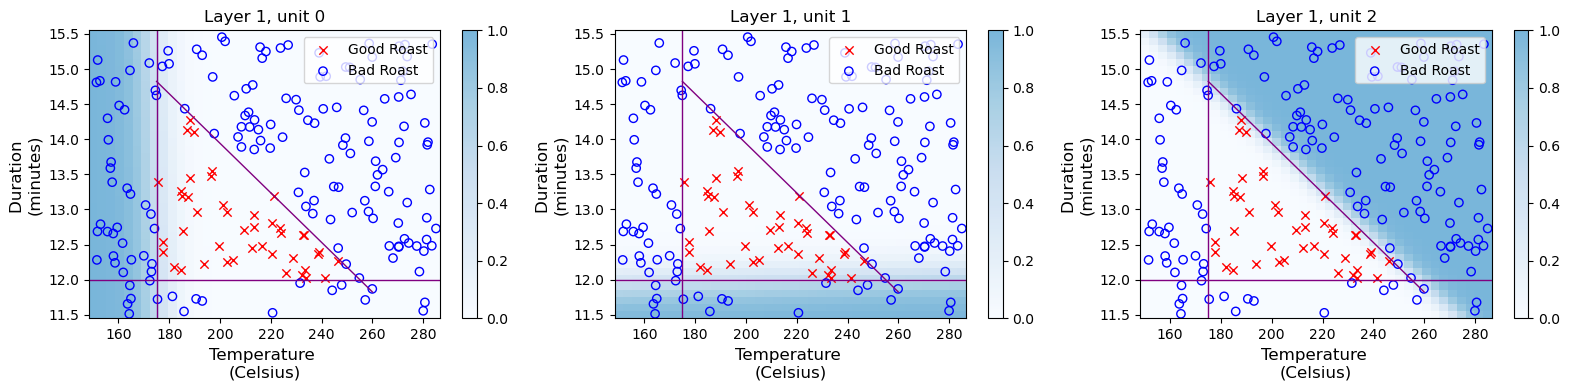

In [22]:
def plt_coffee_roast(X, pos, neg, ax, i):
    temp_range = np.linspace(175, 260,50) #to plot the boundary for good roast
    ax.scatter(X[pos, 0], X[pos, 1], label="Good Roast", c="r", marker="x", lw=1)
    ax.scatter(X[neg, 0], X[neg, 1], label="Bad Roast", marker="o", lw=1, facecolors="none", edgecolors="blue")
    ax.plot(temp_range, (-3 / 85) * temp_range + 21, c="purple", lw=1)
    ax.axhline(y=12, c="purple", lw=1)
    ax.axvline(x=175, c="purple", lw=1)
    
    ax.legend(loc="upper right")
    ax.set_title(f"Layer 1, unit {i}")
    ax.set_xlabel("Temperature \n(Celsius)",size=12)
    ax.set_ylabel("Duration \n(minutes)",size=12)

def truncate_cmap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        "trunc({n}, {a:.2f}, {b:.2f})".format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

def plt_prob(f_wb, ax):
    #creating x and y spaces
    x0_space = np.linspace(150, 285 , 40) #Note: output of a sigmoid function is btwn 0 and 1
    x1_space = np.linspace(11.5, 15.5 , 40)
    
    z = np.zeros((len(x0_space), len(x1_space)))
    tmp_x0, tmp_x1 = np.meshgrid(x0_space, x1_space)
    for i in range(len(x0_space)):
        for j in range(len(x1_space)):
            x = np.array([[tmp_x0[i, j], tmp_x1[i, j]]])
            z[i, j] = f_wb(x)
    
    cmap = plt.get_cmap("Blues")
    new_cmap = truncate_cmap(cmap, minval=0.0, maxval=0.5)
    pcm = ax.pcolormesh(
        tmp_x0, tmp_x1, z, cmap=new_cmap,
        shading="nearest", alpha=0.9,
        norm=cm.colors.Normalize(vmin=0, vmax=1)
    )
    ax.figure.colorbar(pcm, ax=ax)
    
    
def plt_layer(X, y, w, b, norm_layer):
    fig, ax = plt.subplots(1, w.shape[1], figsize=(16, 4))
    y = y.reshape(-1)
    pos = y==1
    neg = y==0
  
    for i in range(w.shape[1]): #layer 1 = 3, layer 2 = 1
        layer_f_wb = lambda x: sigmoid(np.dot(norm_layer(x), w[:, i]) + b[i]) #activation function of each layer
        plt_prob(layer_f_wb, ax[i]) #plotting probabilities
        plt_coffee_roast(X, pos, neg, ax[i], i) #plotting original data
    
    plt.tight_layout()
    plt.show()

#plotting the layer 1 of 3 units/neurons
plt_layer(X, y, W1, b1, norm_layer)

    The shading shows that each unit is responsible for a different "bad roast" region. unit 0 has larger values when the temperature is too low. unit 1 has larger values when the duration is too short and unit 2 has larger values for bad combinations of time/temp. It is worth noting that the network learned these functions on its own through the process of gradient descent. They are very much the same sort of functions a person might choose to make the same decisions.
    
    Notes on pcolormesh:
    ------------------
        The pcolormesh function in Python is used to create a pseudocolor plot with a non-regular rectangular grid. The function takes three arguments: the x-coordinates, the y-coordinates, and the z-coordinates of the data that you want to plot. The function also takes a number of optional arguments, such as the alpha value, the shading style, the colormap, and the normalization.

        The alpha value controls the transparency of the plot. The shading style controls the way that the colors are blended together. The colormap controls the range of colors that are used to plot the data. The normalization controls the way that the data is scaled to fit the colormap.

        To explain the pcolormesh function, you could use the following analogy. Imagine that you have a grid of squares, and each square is a different color. The pcolormesh function allows you to plot a set of data on this grid, and the colors of the squares will represent the values of the data.

        For example, you could use the pcolormesh function to plot a temperature map. The x-coordinates would represent the longitude, the y-coordinates would represent the latitude, and the z-coordinates would represent the temperature. The colors of the squares would then represent the different temperatures.

        The pcolormesh function is a powerful tool for visualizing data. It can be used to plot a wide variety of data, and it can be used to create beautiful and informative plots.

#### Plot the final layer

    The below function plot of the final layer is a bit more difficult to visualize. It's inputs are the output of the first layer. We know that the first layer uses sigmoids so their output range is between zero and one. We can create a 3-D plot that calculates the output for all possible combinations of the three inputs. This is shown below. Above, high output values correspond to 'bad roast' area's. Below, the maximum output is in area's where the three inputs are small values corresponding to 'good roast' area's.

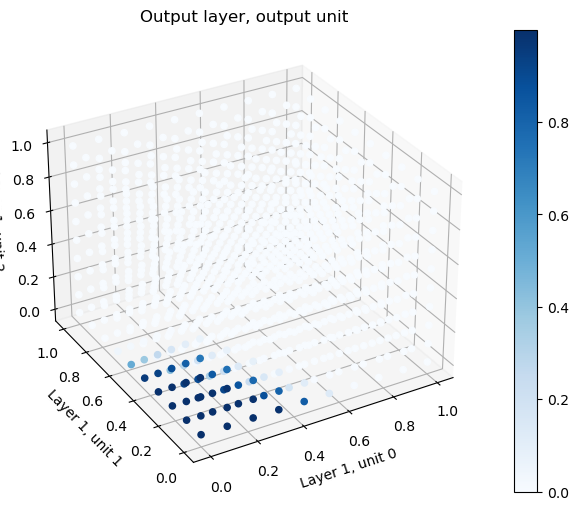

In [23]:
# %matplotlib widget

def plt_output_unit(w, b):
    """ plots a single unit function with 3 inputs of previous layer 3 neurons """
    steps = 10
    x0_space = np.linspace(0, 1, steps) #neurons output is sigmoid (ranges between 0 and 1)
    x1_space = np.linspace(0, 1, steps)
    x2_space = np.linspace(0, 1, steps)
    
    
    temp_x0, temp_x1, temp_x2 = np.meshgrid(x0_space, x1_space, x2_space, indexing="ij") #each has (10, 10, 10)
    out_unit = np.zeros((len(x0_space), len(x1_space), len(x1_space)))
    for i in range(len(x0_space)):
        for j in range(len(x1_space)):
            for k in range(len(x2_space)):
                x = np.array([
                    temp_x0[i, j, k],
                    temp_x1[i, j, k],
                    temp_x2[i, j, k],
                ])
                output_activation =  tf.keras.activations.sigmoid(np.dot(x, w[:, 0]) + b)
                out_unit[i, j, k] = output_activation.numpy()
    #plotting
    fig = plt.figure(figsize=(10, 6))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    cmap = plt.get_cmap("Blues")
    ax = fig.add_subplot(projection="3d")
    pcm = ax.scatter(temp_x0, temp_x1, temp_x2, c=out_unit, cmap=cmap, alpha=1)
    ax.set_xlabel("Layer 1, unit 0")
    ax.set_ylabel("Layer 1, unit 1")
    ax.set_zlabel("Layer 1, unit 2")
    ax.set_title("Output layer, output unit")
    ax.view_init(30, -120)
    ax.figure.colorbar(pcm, ax=ax)
    plt.show()
    
plt_output_unit(W2, b2) 

### Network graph
    The final graph shows the whole network in action.
    The left graph is the raw output of the final layer represented by the blue shading. This is overlaid on the training data represented by the X's and O's.
    The right graph is the output of the network after a decision threshold. The X's and O's here correspond to decisions made by the network.

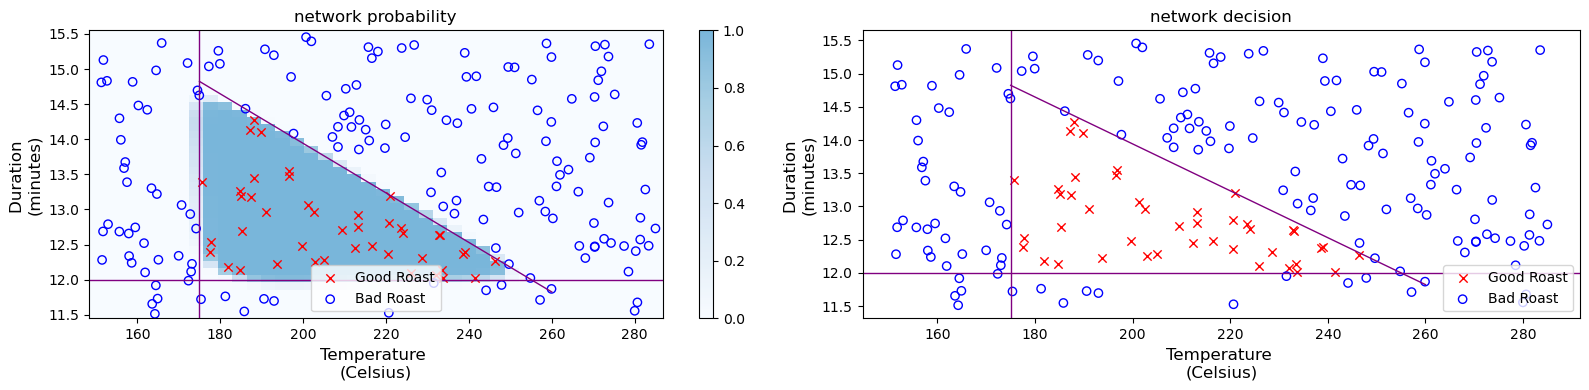

In [39]:
def plt_coffee_roast(X, pos, neg, ax):
    temp_range = np.linspace(175, 260, 50) #to plot the boundary for good roast
    ax.scatter(X[pos, 0], X[pos, 1], label="Good Roast", c="r", marker="x", lw=1)
    ax.scatter(X[neg, 0], X[neg, 1], label="Bad Roast", marker="o", lw=1, facecolors="none", edgecolors="blue")
    ax.plot(temp_range, (-3 / 85) * temp_range + 21, c="purple", lw=1)
    ax.legend()
    ax.axhline(y=12, c="purple", lw=1)
    ax.axvline(x=175, c="purple", lw=1)

def truncate_cmap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        "trunc({n}, {a:.2f}, {b:.2f})".format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap
    
def plt_network(X, y, f_wb):
    fig, ax = plt.subplots(1, 2, figsize=(16, 4))
    y = y.reshape(-1,)
    pos = y==1
    neg = y==0
    
    #creating the spaces
    x0_space = np.linspace(150, 285, 40)
    x1_space = np.linspace(11.5, 15.5, 40)
    
    #creating the grid for shading the area for first plot
    temp_x0, temp_x1 = np.meshgrid(x0_space, x1_space) #(40, 40)
    output = np.zeros_like(temp_x0) #(40, 40)
    
    for i in range(temp_x0.shape[0]):
        for j in range(temp_x1.shape[0]):
            x = np.array([[temp_x0[i, j], temp_x1[i, j]]])
            output[i, j] = f_wb(x)
           
    cmap = plt.get_cmap("Blues")
    new_cmap = truncate_cmap(cmap, minval=0.0, maxval=0.5)
    pcm = ax[0].pcolormesh(temp_x0, temp_x1, output,
                       cmap=new_cmap, alpha=0.9, shading="nearest",
                       norm=cm.colors.Normalize(vmin=0, vmax=1))
    ax[0].figure.colorbar(pcm, ax=ax[0])
    ax[0].set_xlabel("Temperature \n(Celsius)",size=12)
    ax[0].set_ylabel("Duration \n(minutes)",size=12)
    ax[0].set_title(f"network probability")
    plt_coffee_roast(X, pos, neg, ax[0])
    
    output_preds = f_wb(X)
    y_hat = (output_preds >= 0.5).astype(int) #applying threshold
    y_hat = y_hat.reshape(-1)
    pos_hat = y_hat==1
    neg_hat = y_hat==0
    plt_coffee_roast(X, pos_hat, neg_hat, ax[1])
    ax[1].set_title(f"network decision")
    ax[1].set_xlabel("Temperature \n(Celsius)", size=12)
    ax[1].set_ylabel("Duration \n(minutes)", size=12)
    plt.tight_layout()
    plt.show()
            

network_func = lambda x: model.predict(norm_layer(x), verbose=0)
plt.close("all")
plt_network(X, y, network_func)